In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Modules

In [16]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install pydot
%pip install graphviz
%pip install tensorflow
%pip install keras

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img  # Use tf.keras.preprocessing.image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [18]:
BASE_DIR = '/content/drive/MyDrive/newface_extracted/utkcropped/'

In [19]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/11880 [00:00<?, ?it/s]

In [20]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/drive/MyDrive/newface_extracted/utkcr...,30,1
1,/content/drive/MyDrive/newface_extracted/utkcr...,30,1
2,/content/drive/MyDrive/newface_extracted/utkcr...,30,1
3,/content/drive/MyDrive/newface_extracted/utkcr...,30,1
4,/content/drive/MyDrive/newface_extracted/utkcr...,30,1


In [21]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

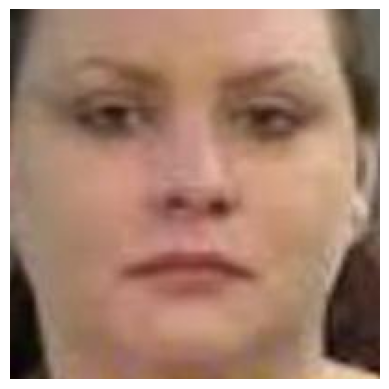

In [22]:
from PIL import Image
img = Image.open(df['image'][10])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

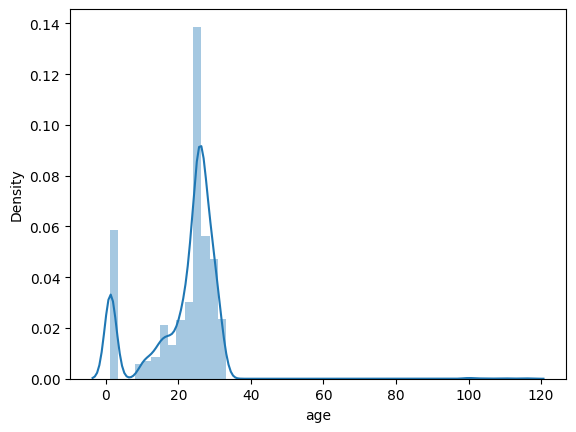

In [23]:
sns.distplot(df['age'])

Text(0.5, 1.0, 'Distribution of Gender')

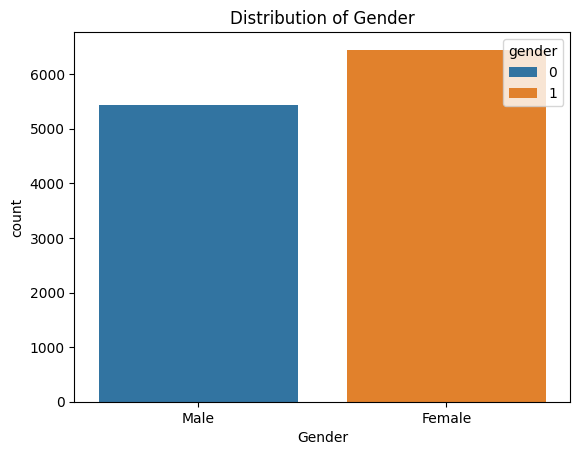

In [24]:
# This line of code is not working it is only showing the total number of images in a form
# of a single column. So i used the updated code below.
# sns.countplot(df['gender'])


# Read the usage of hue in below code for future reference
# By adding the hue='gender' parameter to sns.countplot, it will separate the bars
# by gender (0 for Male, 1 for Female) and display them in different colors.

sns.countplot(x='gender', data=df, hue='gender')
plt.xlabel("Gender")
plt.xticks([0, 1], labels=["Male", "Female"])
plt.title("Distribution of Gender")

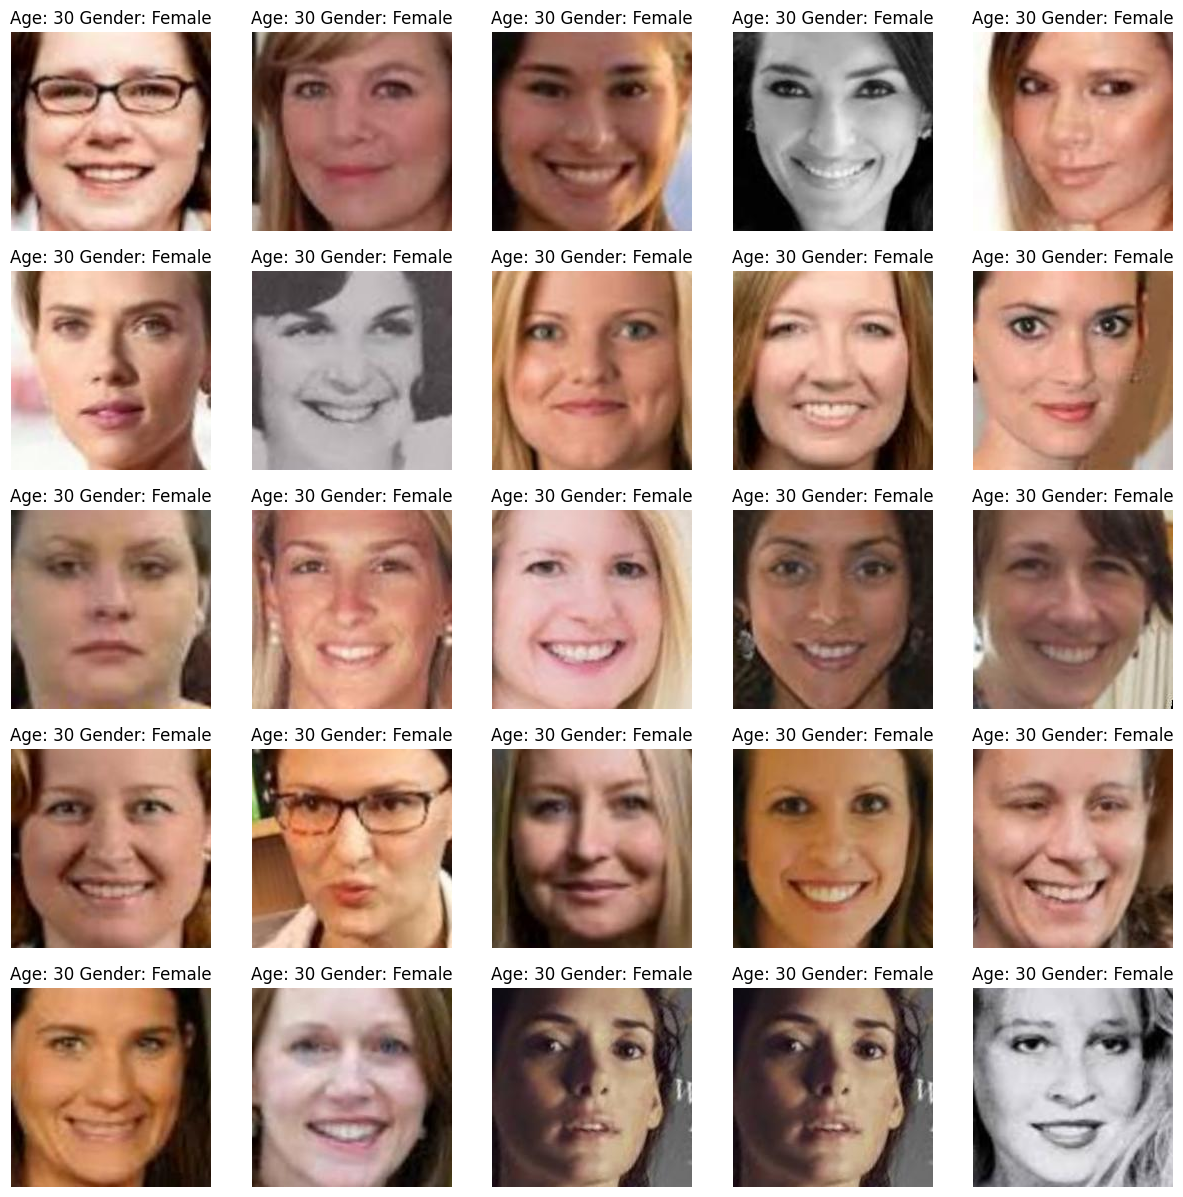

In [25]:
# to display grid of images
plt.figure(figsize=(15, 15))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [26]:
from PIL import Image
from tqdm import tqdm
import numpy as np
from keras.preprocessing.image import load_img

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [27]:
X = extract_features(df['image'])

100%|██████████| 11880/11880 [00:45<00:00, 259.61it/s]


In [28]:
X.shape

(11880, 128, 128, 1)

In [29]:
# normalize the images
X = X/255.0

In [30]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [31]:
input_shape = (128, 128, 1)

## Model Creation

In [32]:
input_shape = (128, 128, 1)

inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=[['accuracy'], ['mae']]) # Provide a list of metrics for each output

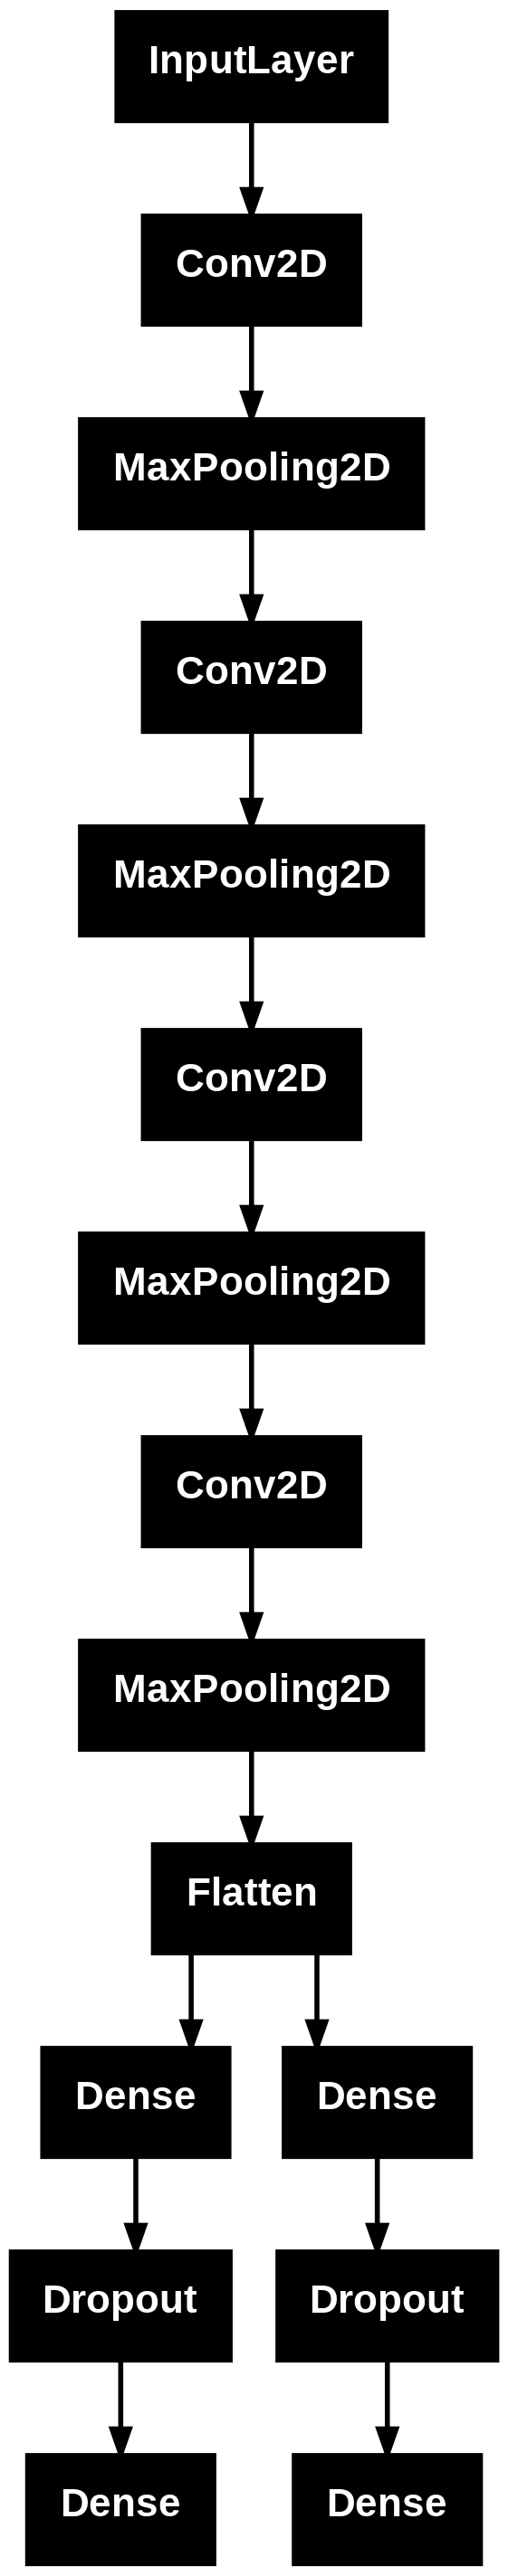

In [33]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [34]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - age_out_loss: 7.1669 - age_out_mae: 7.1669 - gender_out_accuracy: 0.5177 - gender_out_loss: 0.7503 - loss: 7.9171 - val_age_out_loss: 15.0326 - val_age_out_mae: 15.0810 - val_gender_out_accuracy: 0.5354 - val_gender_out_loss: 0.6908 - val_loss: 15.7710
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - age_out_loss: 5.2027 - age_out_mae: 5.2027 - gender_out_accuracy: 0.5515 - gender_out_loss: 0.6862 - loss: 5.8888 - val_age_out_loss: 14.7705 - val_age_out_mae: 14.8188 - val_gender_out_accuracy: 0.5354 - val_gender_out_loss: 0.6883 - val_loss: 15.5062
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - age_out_loss: 4.7963 - age_out_mae: 4.7963 - gender_out_accuracy: 0.5892 - gender_out_loss: 0.6514 - loss: 5.4477 - val_age_out_loss: 10.4970 - val_age_out_mae: 10.5200 - val_gender_out_accuracy: 0.6330 - val_gender_out_loss: 0.6219 - val_loss: 11.1417
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - age_out_loss: 3.59


## Inference

Original Gender: Female Original Age: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
Predicted Gender: Female Predicted Age: 28


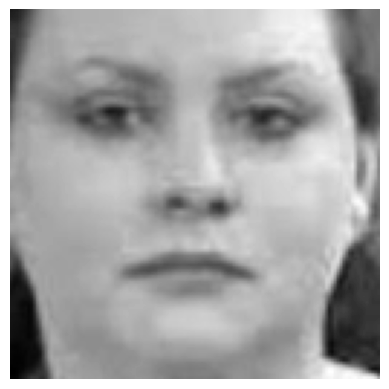

In [35]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Gender: Female Predicted Age: 27


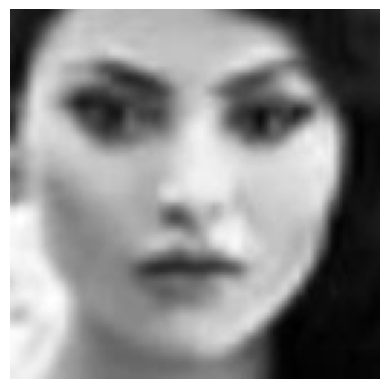

In [36]:
image_index = 305
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Gender: Female Predicted Age: 28


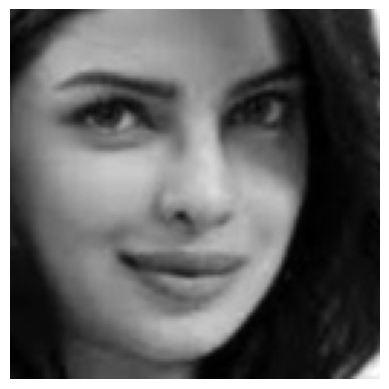

In [37]:
image_index = 2500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Gender: Female Predicted Age: 26


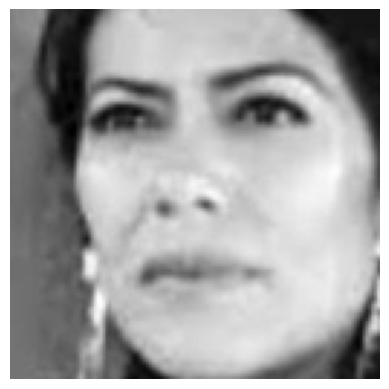

In [38]:
image_index = 2567
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Gender: Male Predicted Age: 2


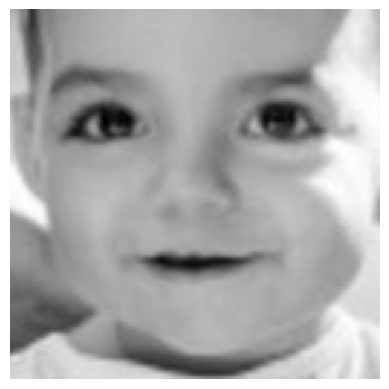

In [39]:
image_index = 1577
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


## Save the model

In [41]:
model.save('age_gender_detection_model.h5')